# Лабораторная работа №4 «Определение числовых характеристик выборки»

## 1) Проанализируйте переменные (столбцы) и укажите, для каких из них определение числовых характеристик имеет смысл. Понимать значения всех характеристик, которые дает метод describe().

In [1]:
import pandas as pd
import numpy as np
from Tools.scripts.dutree import display
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


df = pd.read_csv("DataBikes_new.csv")
df_describe = df.select_dtypes(include='number').copy()
display(df_describe)

,Unnamed: 0,Hour,Temperature,Humidity,Wind speed,Rainfall,Snowfall,Rental count,score
0,0,0,-5.2,37,2.2,0.0,0.0,257,56.0
1,1,1,-5.5,38,0.8,0.0,0.0,219,3.0
2,2,2,-6.0,39,1.0,0.0,0.0,162,7.0
3,3,3,-6.2,40,0.9,0.0,0.0,148,8.0
4,4,4,-6.0,36,2.3,0.0,0.0,97,10.0
...,...,...,...,...,...,...,...,...,...
8755,8755,19,4.2,34,2.6,0.0,0.0,644,55.0
8756,8756,20,3.4,37,2.3,0.0,0.0,359,10.0
8757,8757,21,2.6,39,0.3,0.0,0.0,1236,8.0
8758,8758,22,2.1,41,1.0,0.0,0.0,628,8.0


## 2) Для каждого сезона найдите: среднюю, медианную и модовую температуры, дисперсию, среднеквадратичное отклонение, размах и интерквартильный размах температуры. Результат также выведите в виде общей таблицы.

In [11]:
grouped = df.groupby('Seasons')['Temperature']

stats = pd.DataFrame({
    'mean': grouped.mean(), # Среднее значение температуры для каждого сезона
    'median': grouped.median(), # Медиана (среднее значение в отсортированном наборе)
    'mode': grouped.apply(lambda x: x.mode().iloc[0]), # Мода (наиболее часто встречающееся значение)
    'variance': grouped.var(), # Дисперсия (мера разброса данных)
    'std': grouped.std(),  # Среднеквадратичное отклонение (стандартное отклонение)
    'range': grouped.max() - grouped.min(),  # Размах (разница между максимальным и минимальным значением)
    'IQR': grouped.quantile(0.75) - grouped.quantile(0.25) # Интерквартильный размах (IQR - разница между 75-м и 25-м перцентилями)
})
display(stats)


,mean,median,mode,variance,std,range,IQR
Seasons,,,,,,,
Autumn,14.138821,13.8,10.8,49.589573,7.041986,33.5,11.1
Spring,13.038533,13.3,9.6,43.665630,6.607997,36.0,9.9
Summer,26.574827,26.6,23.4,21.655814,4.653581,23.1,6.7
Winter,-2.567783,-2.2,-1.8,29.877730,5.466052,28.1,7.7


## 3) Переменная «Temperature» содержит None значения. Предложите и реализуйте способ их замены, который по Вашему мнению будет наиболее достоверно соответствовать реальным условиям. Определите, как изменятся при этом числовые характеристики среднего и разброса для температуры.

In [3]:
# Создаём копию
df_filled = df.copy()

# Группируем по Seasons и Hour, заполняем пропуски средним в группе
df_filled['Temperature'] = df_filled.groupby(['Seasons', 'Hour'])['Temperature'].transform(
    lambda x: x.fillna(x.mean())
)

print("До:", df['Temperature'].describe())
print()
print("После:", df_filled['Temperature'].describe())

До: count    8581.000000
mean       12.878557
std        11.955551
min       -17.800000
25%         3.400000
50%        13.700000
75%        22.500000
max        39.400000
Name: Temperature, dtype: float64

После: count    8760.000000
mean       12.874765
std        11.918847
min       -17.800000
25%         3.500000
50%        13.700000
75%        22.500000
max        39.400000
Name: Temperature, dtype: float64


## 4) Предположим, что наблюдения температуры, отклоняющиеся от средней температуры для каждого сезона более чем на два стандартных отклонения, являются выбросами. Сформируйте таблицу без выбросов. Установить, будет ли наблюдаться отличие в характеристиках средних для температуры, построенных на основе исходной и новой таблиц.

In [18]:
df_no_outliers = df_filled.copy()

season_stats = df_no_outliers.groupby('Seasons')['Temperature'].agg(['mean', 'std']).reset_index()

display(season_stats)

# Слияние со статистиками
df_no_outliers = df_no_outliers.merge(season_stats, on='Seasons')

# Фильтрация: оставить только те, где |T - mean| <= 2*std
df_no_outliers = df_no_outliers[
    np.abs(df_no_outliers['Temperature'] - df_no_outliers['mean']) <= 2 * df_no_outliers['std']
]

# Сравнение средних
print("Исходное среднее:", df_filled['Temperature'].mean())
print("Без выбросов:", df_no_outliers['Temperature'].mean())

,Seasons,mean,std
0,Autumn,14.129385,6.978515
1,Spring,13.038048,6.543584
2,Summer,26.573929,4.625311
3,Winter,-2.564298,5.424691


Исходное среднее: 12.874764790276942
Без выбросов: 12.962065115192923


## 5) На одном графике построить размах для каждого месяца. Подписать название графика и его оси.

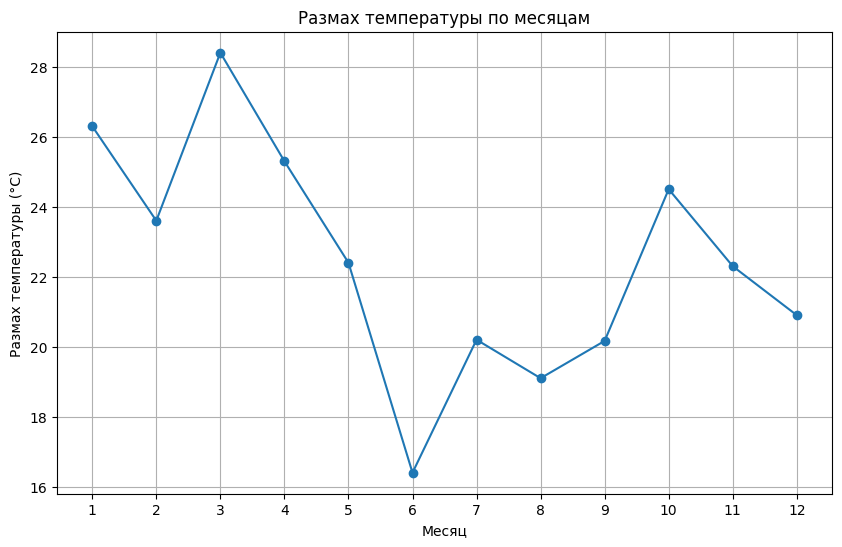

In [22]:
df_plot = df_filled.copy()
df_plot['Date'] = pd.to_datetime(df_plot['Date'], dayfirst=True)
df_plot['Month'] = df_plot['Date'].dt.month

monthly_range = df_plot.groupby('Month')['Temperature'].apply(lambda x: x.max() - x.min())

plt.figure(figsize=(10,6))
plt.plot(monthly_range.index, monthly_range.values, marker='o')
plt.title('Размах температуры по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Размах температуры (°C)')
plt.xticks(range(1,13))
plt.grid(True)
plt.show()

## 6) Найдите, сколько дней работа проката по оценкам была выше среднего. В этом случае следует учитывать, что оценки выставлялись по разным шкалам, поэтому 10 по одной шкале это отлично, а по другой очень плохо. Для решения этой проблемы используют так называемую «z-стандартизацию», т. е. вводят новую переменную z = (x-m)/sigma которая показывает на сколько среднеквадратичных отклонений x отклоняется от среднего.

In [6]:
df_z = df_filled.copy()
df_z['z_score'] = df_z.groupby('score_type')['score'].transform(
    lambda x: (x - x.mean()) / x.std()
)

df_z['Date'] = pd.to_datetime(df_z['Date'], dayfirst=True)

daily_z = df_z.groupby('Date')['z_score'].mean()

above_avg_days = (daily_z > 0).sum()
print(f"Дней с оценкой выше среднего: {above_avg_days}")

Дней с оценкой выше среднего: 182


## 7. Установить наличие линейной зависимости между температурой и числом арендованных велосипедов (по данным за весь год, по сезонам, по месяцам). Для данных, имеющих максимальную линейную зависимость, построить график рассеяния.

In [32]:

df_analysis = df_filled.copy()
df_analysis['Date'] = pd.to_datetime(df_analysis['Date'], dayfirst=True)
df_analysis['Month'] = df_analysis['Date'].dt.month
df_analysis = df_analysis.dropna(subset=['Temperature', 'Rental count'])

best_r = 0
best_group_desc = ""

print("Корреляция между температурой и числом аренд:")


def calculate_pearsonr(best_group_desc, best_r, name, number):
    r, _ = pearsonr(sub['Temperature'], sub['Rental count'])  # Вычисляем корреляцию для этого сезона
    print(f"{name} {number:<10}:           r = {r: .4f}")  # Выводим результат с выравниванием
    if abs(r) > abs(best_r):  # Проверяем, не сильнее ли эта корреляция
        best_r = r  # Обновляем максимальную корреляцию
        best_group_desc = f"{name} {number}"  # Обновляем описание
    return best_group_desc, best_r

# Весь год
r_all, _ = pearsonr(df_analysis['Temperature'], df_analysis['Rental count'])  # Вычисляем корреляцию Пирсона для всех данных
print(f"Весь год:                   r = {r_all: .4f}")  # Выводим результат с форматированием
if abs(r_all) > abs(best_r):  # Сравниваем абсолютное значение с текущим максимумом
    best_r = r_all  # Обновляем лучший коэффициент корреляции
    best_group_desc = "Весь год"  # Обновляем описание группы

# По сезонам
for season in sorted(df_analysis['Seasons'].unique()):  # Итерируем по уникальным сезонам в отсортированном порядке
    sub = df_analysis[df_analysis['Seasons'] == season]  # Фильтруем данные по текущему сезону
    if len(sub) >= 3:  # Проверяем, что в группе достаточно данных (минимум 3 точки)
        best_group_desc, best_r = calculate_pearsonr(best_group_desc, best_r, "Сезон", season)


# По месяцам
for month in sorted(df_analysis['Month'].unique()):  # Итерируем по уникальным месяцам
    sub = df_analysis[df_analysis['Month'] == month]  # Фильтруем данные по текущему месяцу
    if len(sub) >= 3:  # Проверяем достаточность данных
        best_group_desc, best_r  = calculate_pearsonr(best_group_desc, best_r, "Месяц", month)

print(f"Максимальная корреляция: {best_group_desc} (r = {best_r:.4f})")  # Выводим итоговый результат



Корреляция между температурой и числом аренд:
Весь год:                   r =  0.4541
Сезон Autumn    :           r =  0.2583
Сезон Spring    :           r =  0.4683
Сезон Summer    :           r =  0.1334
Сезон Winter    :           r =  0.3017
Месяц 1         :           r =  0.2993
Месяц 2         :           r =  0.4051
Месяц 3         :           r =  0.4303
Месяц 4         :           r =  0.5080
Месяц 5         :           r =  0.3819
Месяц 6         :           r =  0.3827
Месяц 7         :           r =  0.2512
Месяц 8         :           r =  0.1661
Месяц 9         :           r =  0.3972
Месяц 10        :           r =  0.2134
Месяц 11        :           r =  0.1164
Месяц 12        :           r =  0.1774
Максимальная корреляция: Месяц 4 (r = 0.5080)


## Построение графика

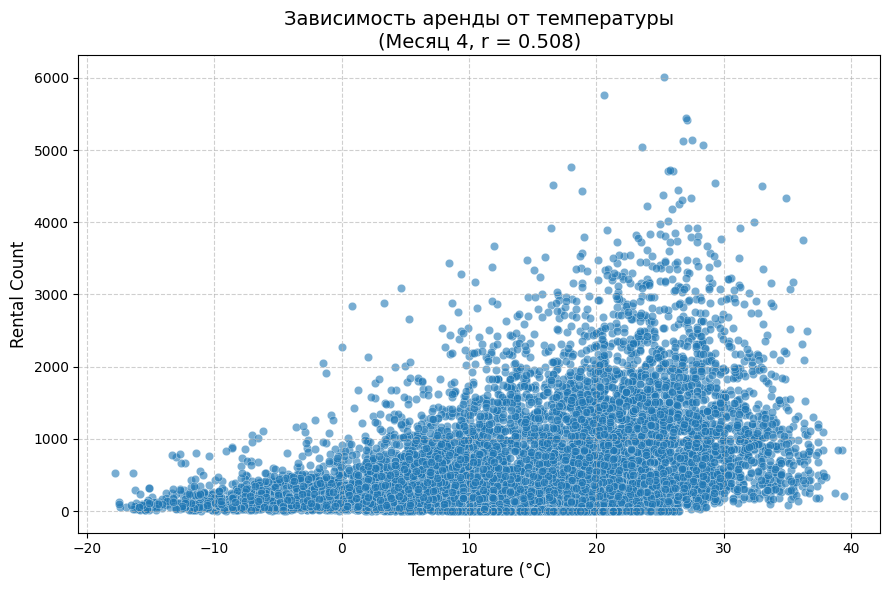

In [8]:
# Определяем, какие данные использовать для построения графика
if best_group_desc == 'Весь год':  # Если максимальная корреляция для всего года
    plot_data = df_analysis  # Используем все данные
elif best_group_desc.startswith('Season: '):  # Если максимальная корреляция для какого-то сезона
    season_name = best_group_desc.replace('Season: ', '')  # Извлекаем название сезона из строки
    plot_data = df_analysis[df_analysis['Seasons'] == season_name]  # Фильтруем данные по этому сезону
elif best_group_desc.startswith('Month: '):  # Если максимальная корреляция для какого-то месяца
    month_num = int(best_group_desc.replace('Month: ', ''))  # Извлекаем номер месяца и преобразуем в число
    plot_data = df_analysis[df_analysis['Month'] == month_num]  # Фильтруем данные по этому месяцу
else:  # На всякий случай (запасной вариант)
    plot_data = df_analysis  # Используем все данные

# Создаем график рассеяния (scatter plot) для визуализации зависимости
plt.figure(figsize=(9, 6))  # Создаем фигуру размером 9x6 дюймов
plt.scatter(plot_data['Temperature'], plot_data['Rental count'],  # По оси X - температура, по Y - количество аренд
            alpha=0.6,  # Полупрозрачные точки для лучшей визуализации перекрывающихся данных
            edgecolors='w',  # Белые границы у точек
            linewidth=0.3)  # Тонкая граница у точек

# Добавляем заголовок графика с информацией о группе и коэффициенте корреляции
plt.title(f'Зависимость аренды от температуры\n({best_group_desc}, r = {best_r:.3f})', fontsize=14)

# Подписываем оси
plt.xlabel('Temperature (°C)', fontsize=12)  # Ось X - температура в градусах Цельсия
plt.ylabel('Rental Count', fontsize=12)  # Ось Y - количество аренд

plt.grid(True, linestyle='--', alpha=0.6)  # Добавляем сетку пунктирными линиями с прозрачностью
plt.tight_layout()  # Автоматически настраиваем отступы для красивого отображения
plt.show()  # Отображаем график

## 8. Аналогичные п.7 исследования провести для температуры и оценки.

In [35]:
df_z = df_filled.copy()
df_z['Date'] = pd.to_datetime(df_z['Date'], dayfirst=True)
df_z['Month'] = df_z['Date'].dt.month
df_z['z_score'] = df_z.groupby('score_type')['score'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Удаление пропусков
df_corr = df_z.dropna(subset=['Temperature', 'z_score'])

best_r = 0
best_group_desc = ""

print("Корреляция между температурой и оценкой (после z-стандартизации):")

def calculate_pearsonr2(best_group_desc, best_r, name, number):
    r, _ = pearsonr(sub['Temperature'], sub['z_score'])  # Вычисляем корреляцию для этого сезона
    print(f"{name} {number:<10}:           r = {r: .4f}")  # Выводим результат с выравниванием
    if abs(r) > abs(best_r):  # Проверяем, не сильнее ли эта корреляция
        best_r = r  # Обновляем максимальную корреляцию
        best_group_desc = f"{name} {number}"  # Обновляем описание
    return best_group_desc, best_r

# Весь год
r_all, _ = pearsonr(df_corr['Temperature'], df_corr['z_score'])
print(f"Весь год:                   r = {r_all: .4f}")
if abs(r_all) > abs(best_r):
    best_r = r_all
    best_group_desc = "Весь год"

# По сезонам
for season in sorted(df_corr['Seasons'].unique()):
    sub = df_corr[df_corr['Seasons'] == season]
    if len(sub) >= 3:
        best_group_desc, best_r = calculate_pearsonr2(best_group_desc, best_r, "Сезон", season)

# По месяцам
for month in sorted(df_corr['Month'].unique()):
    sub = df_corr[df_corr['Month'] == month]
    if len(sub) >= 3:
        best_group_desc, best_r = calculate_pearsonr2(best_group_desc, best_r, "Месяц", month)

print(f"Максимальная корреляция: {best_group_desc} (r = {best_r:.4f})")

Корреляция между температурой и оценкой (после z-стандартизации):
Весь год:                   r = -0.0032
Сезон Autumn    :           r = -0.0204
Сезон Spring    :           r =  0.0375
Сезон Summer    :           r =  0.0191
Сезон Winter    :           r = -0.0493
Месяц 1         :           r = -0.0702
Месяц 2         :           r = -0.0363
Месяц 3         :           r = -0.0026
Месяц 4         :           r = -0.0171
Месяц 5         :           r =  0.0401
Месяц 6         :           r = -0.0159
Месяц 7         :           r =  0.0304
Месяц 8         :           r =  0.0286
Месяц 9         :           r =  0.0182
Месяц 10        :           r = -0.0165
Месяц 11        :           r =  0.0090
Месяц 12        :           r = -0.0295
Максимальная корреляция: Месяц 1 (r = -0.0702)


## Построение графика

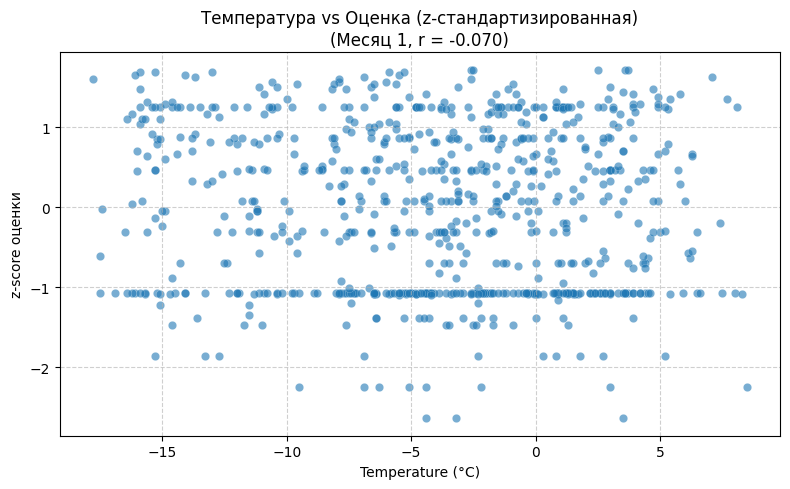

In [36]:
if best_group_desc == "Весь год":
    plot_data = df_corr
elif best_group_desc.startswith("Сезон "):
    season_name = best_group_desc.replace("Сезон ", "")
    plot_data = df_corr[df_corr['Seasons'] == season_name]
elif best_group_desc.startswith("Месяц "):
    month_num = int(best_group_desc.replace("Месяц ", ""))
    plot_data = df_corr[df_corr['Month'] == month_num]
else:
    plot_data = df_corr

plt.figure(figsize=(8, 5))
plt.scatter(plot_data['Temperature'], plot_data['z_score'], alpha=0.6, edgecolor='w', linewidth=0.2)
plt.title(f'Температура vs Оценка (z-стандартизированная)\n({best_group_desc}, r = {best_r:.3f})', fontsize=12)
plt.xlabel('Temperature (°C)')
plt.ylabel('z-score оценки')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()